<a href="https://colab.research.google.com/github/sakshi-sketch/Marathi_Sentiment_analysis/blob/main/marathi_sentiment_analaysis_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install nltk

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('/content/MAR_SA.csv')
print(df.info())
print(df.head(5))
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7490 entries, 0 to 7489
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  7490 non-null   object 
 1   label    7476 non-null   float64
dtypes: float64(1), object(1)
memory usage: 117.2+ KB
None
                                            comment  label
0                  प्रत्येक संघात सात खेळाडू असतात.    0.0
1                समस्येचे निराकरण करणे शक्य आहे का?    0.0
2           यावर श्रेयासाठी कोणीच काही केलेले नाही.    0.0
3     त्यानंतर दिल्लीमध्ये पुढचं शिक्षण पूर्ण केलं.    0.0
4  यावर भाजपने तीव्र नाराजीची प्रतिक्रिया दिली आहे.   -1.0
             label
count  7476.000000
mean      0.015115
std       0.533467
min      -1.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


Tokenization

In [4]:
# 2. Drop rows with missing labels
df = df.dropna(subset=['label'])

# 3. Convert label to int
df = df.dropna(subset=['label']).copy()  # <-- Make an explicit copy

# Now safely convert to int
df.loc[:, 'label'] = df['label'].astype(int)




In [5]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
 #📌 Step 4: Text Preprocessing (optional basic clean)
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)      # remove numbers
    return text.strip()

df['comment'] = df['comment'].astype(str).apply(clean_text)


In [7]:
# 📌 Step 5: Tokenize & Pad Sequences
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['comment'])

X = tokenizer.texts_to_sequences(df['comment'])
X = pad_sequences(X, maxlen=max_len)

y = to_categorical(df['label'] + 1)  # shift labels from (-1,0,1) to (0,1,2)

out of vocabulary tokenizer (oov)

In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000
max_len = 100
extra_sentences = [
    "मी वाईट आहे",
    "माझा दिवस छान आहे",
    "माझं आयुष्य सुंदर आहे",
    "मी खूप आनंदी आहे",
    "मी दुःखी आहे",
    "हे एक वाईट स्वप्न आहे"
]

# Combine original comments with new examples
all_texts = df['comment'].tolist() + extra_sentences

# Refit tokenizer with oov_token
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(all_texts)

# Add oov_token to handle unseen words properly
#tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
#tokenizer.fit_on_texts(df['comment'])

# Convert text to sequences
X = tokenizer.texts_to_sequences(df['comment'])
X = pad_sequences(X, maxlen=max_len)

# One-hot encode labels (-1, 0, 1) → (0, 1, 2)
#y = to_categorical(df['label'] + 1)
y = df['label'] + 1  # Labels are now in (0, 1, 2) format.

In [44]:
# 📌 Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [45]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights = dict(enumerate(class_weights))

In [48]:
# 📌 Step 7: Build LSTM Model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes: -1, 0, 1

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [49]:
# 📌 Step 8: Train Model
history =  model.fit(X, y, epochs=5, batch_size=32, class_weight=class_weights)

Epoch 1/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.4516 - loss: 1.0549
Epoch 2/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.7435 - loss: 0.5818
Epoch 3/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.8746 - loss: 0.2773
Epoch 4/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.9238 - loss: 0.1816
Epoch 5/5
234/234 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - accuracy: 0.9500 - loss: 0.1143


In [50]:
# ✅ Save the model
model.save('marathi_sentiment_lstm_oov.h5')

# 📥 Optionally download it to your local machine
from google.colab import files
files.download('marathi_sentiment_lstm_oov.h5')
print(tokenizer.texts_to_sequences(["मी वाईट आहे"]))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[3247, 5159, 1599]]


In [51]:
print("मी" in tokenizer.word_index)
print("वाईट" in tokenizer.word_index)
print("आहे" in tokenizer.word_index)

True
True
True


In [52]:
# Sample input text
text = "मी वाईट आहे"

# Convert to sequence
seq = tokenizer.texts_to_sequences([text])
padded = pad_sequences(seq, maxlen=max_len)

# Predict using model
pred = model.predict(padded)

# Print softmax scores and prediction
print("Softmax Output:", pred)
print("Predicted Class Index:", np.argmax(pred))
print("Predicted Sentiment Label:", le.inverse_transform([np.argmax(pred)]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Softmax Output: [[0.3737083 0.239688  0.3866037]]
Predicted Class Index: 2
Predicted Sentiment Label: [2]


In [53]:
!pip install gradio

In [55]:
print(tokenizer.texts_to_sequences(["मी वाईट आहे"]))

[[3247, 5159, 1599]]


In [61]:
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load model
model = tf.keras.models.load_model("/content/marathi_sentiment_lstm.h5")

# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load label encoder or class labels
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

max_len = 100  # Change to match your training setup

# Prediction function
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded)
    label = le.inverse_transform([np.argmax(pred)])

    # Printing the sentiment label clearly
    if label[0] == 0:
        sentiment = "Netural"
    elif label[0] == 1:
        sentiment = "Negative"
    else:
        sentiment = "Positive"

    return sentiment

# Gradio UI
iface = gr.Interface(fn=predict_sentiment,
                     inputs=gr.Textbox(label="Enter Marathi Text"),
                     outputs=gr.Textbox(label="Predicted Sentiment"),
                     title="Marathi Sentiment Analysis",
                     description="Enter a sentence in Marathi to analyze its sentiment.")

# Launch the interface
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d7477cfbe2b668fb2e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [12]:
# 📌 Step 9: Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {acc:.2f}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6844 - loss: 1.1792
Test Accuracy: 0.68


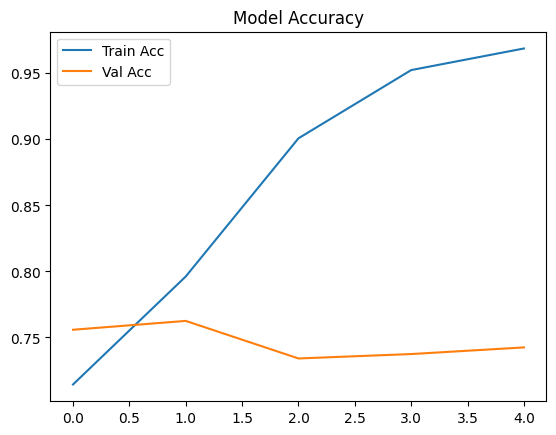

In [ ]:

# 📌 Step 10: Plot Accuracy & Loss
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()
plt.show()

BILSTM

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming `df['comment']` is your input and `df['label']` is your target
max_words = 10000
max_len = 100  # or 200 depending on avg sentence length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['comment'])

sequences = tokenizer.texts_to_sequences(df['comment'])
padded = pad_sequences(sequences, maxlen=max_len)

# Check shape (num_samples, sequence_length)
print(padded.shape)

(7476, 100)


In [ ]:
from tensorflow.keras.utils import to_categorical

# Ensure labels are integers: -1, 0, 1 → 0, 1, 2
df['label'] = df['label'].map({-1: 0, 0: 1, 1: 2}).astype(int)

# One-hot encode the labels
labels = to_categorical(df['label'], num_classes=3)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded, labels, test_size=0.2, random_state=42
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense

model_bilstm = Sequential()
model_bilstm.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model_bilstm.add(Bidirectional(LSTM(64)))
model_bilstm.add(Dropout(0.5))
model_bilstm.add(Dense(64, activation='relu'))
model_bilstm.add(Dense(3, activation='softmax'))

model_bilstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_bilstm.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.1)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


337/337 ━━━━━━━━━━━━━━━━━━━━ 63s 157ms/step - accuracy: 0.7107 - loss: 0.8155 - val_accuracy: 0.7609 - val_loss: 0.6203
Epoch 2/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 81s 155ms/step - accuracy: 0.8206 - loss: 0.4725 - val_accuracy: 0.7642 - val_loss: 0.6110
Epoch 3/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 81s 152ms/step - accuracy: 0.9283 - loss: 0.2184 - val_accuracy: 0.7441 - val_loss: 0.7127
Epoch 4/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.9646 - loss: 0.1123 - val_accuracy: 0.7408 - val_loss: 0.8730
Epoch 5/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 51s 152ms/step - accuracy: 0.9769 - loss: 0.0724 - val_accuracy: 0.7140 - val_loss: 1.1405
Epoch 6/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 82s 151ms/step - accuracy: 0.9867 - loss: 0.0461 - val_accuracy: 0.7308 - val_loss: 1.4163
Epoch 7/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 85s 159ms/step - accuracy: 0.9921 - loss: 0.0282 - val_accuracy: 0.6973 - val_loss: 1.5675
Epoch 8/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 52s 153ms/step - accuracy: 0.9922 - loss: 0.0269 - val

In [ ]:
# ✅ Save the model
model.save('marathi_sentiment_bilstm1.h5')

# 📥 Optionally download it to your local machine
from google.colab import files
files.download('marathi_sentiment_bilstm1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7030 - loss: 2.2925
Test Accuracy: 0.70


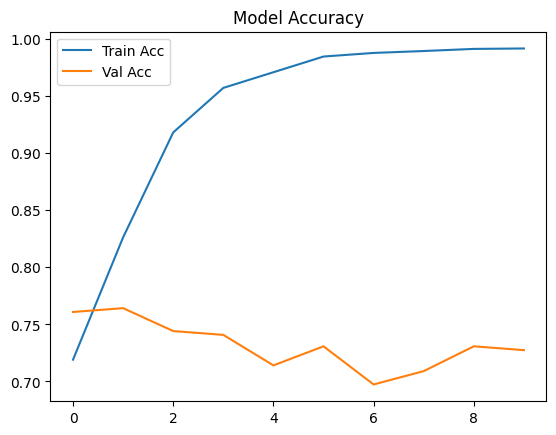

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {acc:.2f}')

# 📌 Step 10: Plot Accuracy & Loss
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()
plt.show()

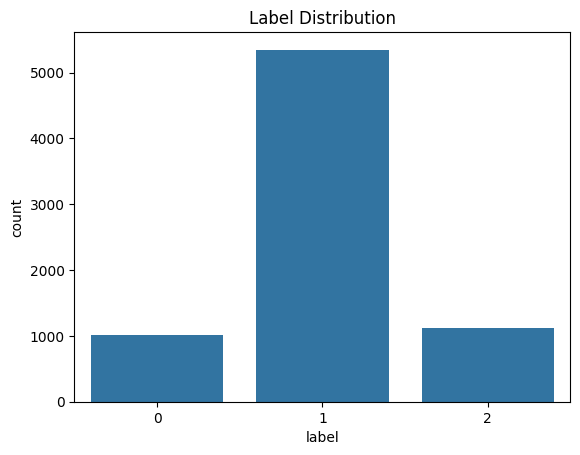

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df['label'])
plt.title('Label Distribution')
plt.show()

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label']),
    y=df['label']
)
#handle imbalance
# Pass to fit
model_bilstm.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    class_weight=dict(enumerate(class_weights))
)

Epoch 1/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 54s 149ms/step - accuracy: 0.9934 - loss: 0.0333 - val_accuracy: 0.6856 - val_loss: 2.3431
Epoch 2/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 84s 155ms/step - accuracy: 0.9929 - loss: 0.0180 - val_accuracy: 0.6856 - val_loss: 2.3579
Epoch 3/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 81s 151ms/step - accuracy: 0.9884 - loss: 0.0364 - val_accuracy: 0.6823 - val_loss: 1.7901
Epoch 4/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 81s 149ms/step - accuracy: 0.9878 - loss: 0.0306 - val_accuracy: 0.6756 - val_loss: 2.3302
Epoch 5/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 84s 155ms/step - accuracy: 0.9980 - loss: 0.0061 - val_accuracy: 0.6906 - val_loss: 2.4604
Epoch 6/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 78s 142ms/step - accuracy: 0.9976 - loss: 0.0084 - val_accuracy: 0.6639 - val_loss: 2.6223
Epoch 7/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 84s 148ms/step - accuracy: 0.9973 - loss: 0.0064 - val_accuracy: 0.6923 - val_loss: 2.6863
Epoch 8/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 83s 151ms/step - accuracy: 0.9971 - loss: 0

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Predict
y_pred = model_bilstm.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test.argmax(axis=1)

# Report
print(classification_report(y_true_classes, y_pred_classes, digits=4))

47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step
              precision    recall  f1-score   support

           0     0.4065    0.4545    0.4292       220
           1     0.8119    0.7024    0.7532      1045
           2     0.3931    0.5887    0.4714       231

    accuracy                         0.6484      1496
   macro avg     0.5372    0.5819    0.5513      1496
weighted avg     0.6876    0.6484    0.6620      1496



GRU

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# GRU Model
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model_gru.add(GRU(64, return_sequences=False))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(3, activation='softmax'))

# Compile
model_gru.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 125ms/step - accuracy: 0.6952 - loss: 0.8529 - val_accuracy: 0.7742 - val_loss: 0.6165
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - accuracy: 0.7995 - loss: 0.5226 - val_accuracy: 0.7525 - val_loss: 0.6111
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 124ms/step - accuracy: 0.9095 - loss: 0.2549 - val_accuracy: 0.7525 - val_loss: 0.7387
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.9625 - loss: 0.1260 - val_accuracy: 0.7559 - val_loss: 0.8788
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.9798 - loss: 0.0681 - val_accuracy: 0.7258 - val_loss: 0.9887
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - accuracy: 0.9770 - loss: 0.0615 - val_accuracy: 0.7074 - val_loss: 1.1387
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.9875 - loss: 0.0438 - val_accuracy: 0.7191 - val_loss: 1.3989
Epoch 8/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.9924 - loss: 0.0287 - val

In [ ]:
# ✅ Save the model
model.save('marathi_sentiment_gru.h5')

# 📥 Optionally download it to your local machine
from google.colab import files
files.download('marathi_sentiment_gru.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Predict
y_pred_gru = model_gru.predict(X_test)
y_pred_classes = y_pred_gru.argmax(axis=1)
y_true_classes = y_test.argmax(axis=1)

# Metrics
print("🔹 GRU Model Metrics")
print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))
print("Precision:", precision_score(y_true_classes, y_pred_classes, average='weighted'))
print("Recall:", recall_score(y_true_classes, y_pred_classes, average='weighted'))
print("F1 Score:", f1_score(y_true_classes, y_pred_classes, average='weighted'))

# Detailed report
print(classification_report(y_true_classes, y_pred_classes, digits=4))

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
🔹 GRU Model Metrics
Accuracy: 0.7025401069518716
Precision: 0.690300033056701
Recall: 0.7025401069518716
F1 Score: 0.6953067104698203
              precision    recall  f1-score   support

           0     0.4184    0.3727    0.3942       220
           1     0.7862    0.8306    0.8078      1045
           2     0.5153    0.4372    0.4731       231

    accuracy                         0.7025      1496
   macro avg     0.5733    0.5469    0.5584      1496
weighted avg     0.6903    0.7025    0.6953      1496



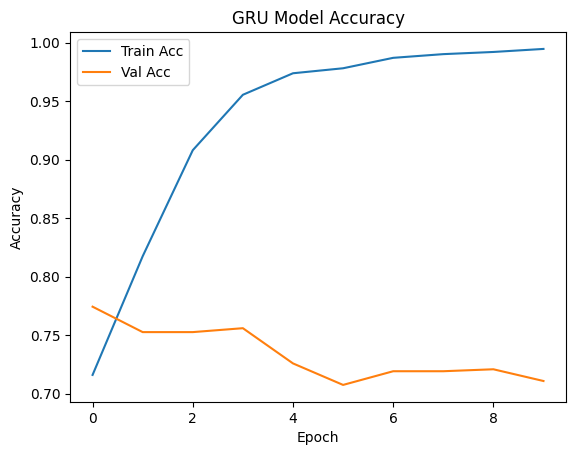

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_gru.history['accuracy'], label='Train Acc')
plt.plot(history_gru.history['val_accuracy'], label='Val Acc')
plt.title('GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load model
model = tf.keras.models.load_model("marathi_sentiment_bilstm.h5")

# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load label encoder or class labels
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

max_len = 100  # Change to match your training setup

# Prediction function
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded)
    label = le.inverse_transform([np.argmax(pred)])

    # Printing the sentiment label clearly
    if label[0] == 0:
        sentiment = "Negative"
    elif label[0] == 1:
        sentiment = "Neutral"
    else:
        sentiment = "Positive"

    return sentiment

# Gradio UI
iface = gr.Interface(fn=predict_sentiment,
                     inputs=gr.Textbox(label="Enter Marathi Text"),
                     outputs=gr.Textbox(label="Predicted Sentiment"),
                     title="Marathi Sentiment Analysis",
                     description="Enter a sentence in Marathi to analyze its sentiment.")

# Launch the interface
iface.launch(share=True)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# LSTM Evaluation
y_pred_lstm = model.predict(X_test)
y_pred_lstm_classes = y_pred_lstm.argmax(axis=1)
y_true_classes = y_test.argmax(axis=1)

print("🔹 LSTM Metrics:")
print("Accuracy:", accuracy_score(y_true_classes, y_pred_lstm_classes))
print("Precision:", precision_score(y_true_classes, y_pred_lstm_classes, average='weighted'))
print("Recall:", recall_score(y_true_classes, y_pred_lstm_classes, average='weighted'))
print("F1 Score:", f1_score(y_true_classes, y_pred_lstm_classes, average='weighted'))
print(classification_report(y_true_classes, y_pred_lstm_classes, digits=4))

# BiLSTM Evaluation
y_pred_bilstm = model_bilstm.predict(X_test)
y_pred_bilstm_classes = y_pred_bilstm.argmax(axis=1)

print("🔹 BiLSTM Metrics:")
print("Accuracy:", accuracy_score(y_true_classes, y_pred_bilstm_classes))
print("Precision:", precision_score(y_true_classes, y_pred_bilstm_classes, average='weighted'))
print("Recall:", recall_score(y_true_classes, y_pred_bilstm_classes, average='weighted'))
print("F1 Score:", f1_score(y_true_classes, y_pred_bilstm_classes, average='weighted'))
print(classification_report(y_true_classes, y_pred_bilstm_classes, digits=4))

# GRU Evaluation
y_pred_gru = model_gru.predict(X_test)
y_pred_gru_classes = y_pred_gru.argmax(axis=1)

print("🔹 GRU Metrics:")
print("Accuracy:", accuracy_score(y_true_classes, y_pred_gru_classes))
print("Precision:", precision_score(y_true_classes, y_pred_gru_classes, average='weighted'))
print("Recall:", recall_score(y_true_classes, y_pred_gru_classes, average='weighted'))
print("F1 Score:", f1_score(y_true_classes, y_pred_gru_classes, average='weighted'))
print(classification_report(y_true_classes, y_pred_gru_classes, digits=4))

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step
🔹 LSTM Metrics:
Accuracy: 0.6978609625668449
Precision: 0.6874302639102753
Recall: 0.6978609625668449
F1 Score: 0.6918211585883007
              precision    recall  f1-score   support

           0     0.4333    0.3545    0.3900       220
           1     0.7906    0.8239    0.8069      1045
           2     0.4626    0.4545    0.4585       231

    accuracy                         0.6979      1496
   macro avg     0.5622    0.5443    0.5518      1496
weighted avg     0.6874    0.6979    0.6918      1496

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step
🔹 BiLSTM Metrics:
Accuracy: 0.6483957219251337
Precision: 0.6876424434789778
Recall: 0.6483957219251337
F1 Score: 0.6620427534067932
              precision    recall  f1-score   support

           0     0.4065    0.4545    0.4292       220
           1     0.8119    0.7024    0.7532      1045
           2     0.3931    0.5887    0.4714       231

    accuracy                         0.6484      1496
   

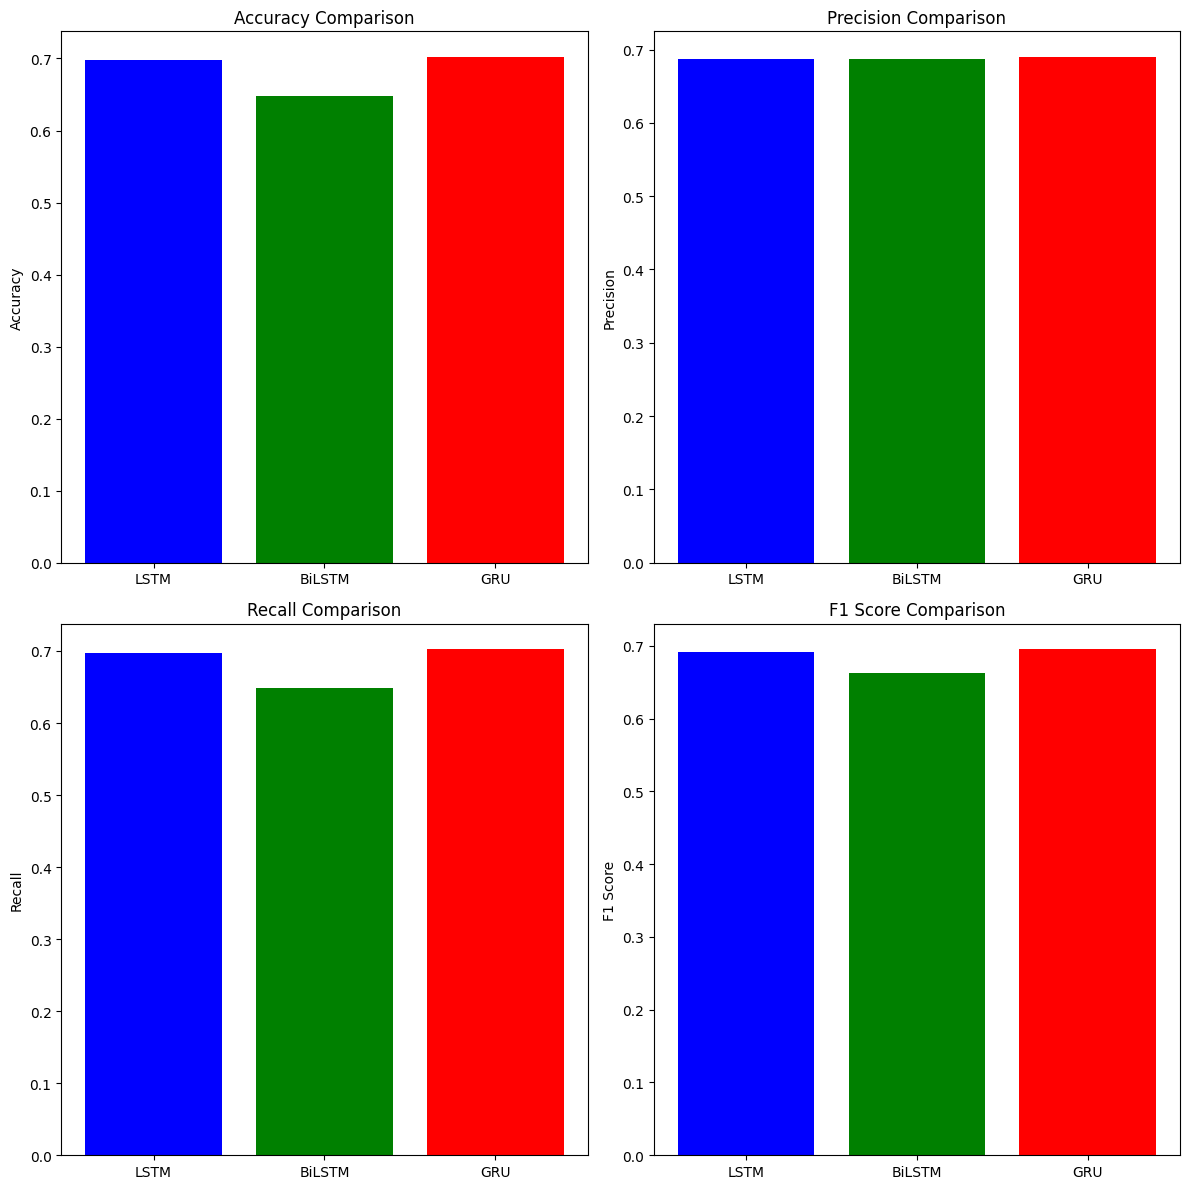

In [ ]:
import matplotlib.pyplot as plt

# Collect metrics for plotting
models = ['LSTM', 'BiLSTM', 'GRU']
accuracy = [
    accuracy_score(y_true_classes, y_pred_lstm_classes),
    accuracy_score(y_true_classes, y_pred_bilstm_classes),
    accuracy_score(y_true_classes, y_pred_gru_classes)
]

precision = [
    precision_score(y_true_classes, y_pred_lstm_classes, average='weighted'),
    precision_score(y_true_classes, y_pred_bilstm_classes, average='weighted'),
    precision_score(y_true_classes, y_pred_gru_classes, average='weighted')
]

recall = [
    recall_score(y_true_classes, y_pred_lstm_classes, average='weighted'),
    recall_score(y_true_classes, y_pred_bilstm_classes, average='weighted'),
    recall_score(y_true_classes, y_pred_gru_classes, average='weighted')
]

f1 = [
    f1_score(y_true_classes, y_pred_lstm_classes, average='weighted'),
    f1_score(y_true_classes, y_pred_bilstm_classes, average='weighted'),
    f1_score(y_true_classes, y_pred_gru_classes, average='weighted')
]

# Plot comparison
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# Accuracy plot
ax[0, 0].bar(models, accuracy, color=['blue', 'green', 'red'])
ax[0, 0].set_title('Accuracy Comparison')
ax[0, 0].set_ylabel('Accuracy')

# Precision plot
ax[0, 1].bar(models, precision, color=['blue', 'green', 'red'])
ax[0, 1].set_title('Precision Comparison')
ax[0, 1].set_ylabel('Precision')

# Recall plot
ax[1, 0].bar(models, recall, color=['blue', 'green', 'red'])
ax[1, 0].set_title('Recall Comparison')
ax[1, 0].set_ylabel('Recall')

# F1 Score plot
ax[1, 1].bar(models, f1, color=['blue', 'green', 'red'])
ax[1, 1].set_title('F1 Score Comparison')
ax[1, 1].set_ylabel('F1 Score')

plt.tight_layout()
plt.show()

In [ ]:
!pip install gradio
!pip install tensorflow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
texts = df['comment'].astype(str).tolist()
labels = df['label'].astype(int).tolist()
# Create tokenizer
max_words = 5000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# Save tokenizer for future use
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences
max_len = 100  # You can adjust based on your model
X = pad_sequences(sequences, maxlen=max_len)

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode and save label encoder
le = LabelEncoder()
y = le.fit_transform(labels)
y = to_categorical(y)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

In [ ]:
from google.colab import files

# Download tokenizer
files.download('tokenizer.pkl')

# Download label encoder
files.download('label_encoder.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load model
model = tf.keras.models.load_model("marathi_sentiment_bilstm.h5")

# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load label encoder or class labels
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

max_len = 100  # Change to match your training setup

# Prediction function
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded)
    label = le.inverse_transform([np.argmax(pred)])
    return label[0]

# Gradio UI
iface = gr.Interface(fn=predict_sentiment,
                     inputs=gr.Textbox(label="Enter Marathi Text"),
                     outputs=gr.Textbox(label="Predicted Sentiment"),
                     title="Marathi Sentiment Analysis",
                     description="Enter a sentence in Marathi to analyze its sentiment.")

# Launch the interface
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://368b17d36e9a1df0de.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
